# Spam Analysis

### Ideas for spam analysis

#### Supervised
- Predict whether a message is spam or not
- Test accuracy of spam filter

    1. Convert messages to a TF-IDF matrix where each word represents a dimension
    2. Split dataset into a training and test set
        - 80/20
        - k cross-validation
    3. Run classifier model on the TF-IDF matrix
    4. Evaluate model accuracy

#### Unsupervised
- Find top words for spam messages
- Identify topics within the spam messages

In [1]:
# load libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('max_column', None)
pd.set_option('max_row',None)
pd.set_option('max_colwidth',-1)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, average_precision_score, roc_auc_score, f1_score
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict#, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
# from sklearn.tree import DecisionTreeClassifier 
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve

from sklearn.decomposition import LatentDirichletAllocation

/Users/annalie/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/annalie/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/annalie/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0

In [3]:
# load dataset
df = pd.read_csv('sms_spam_collection.csv', usecols=['v1', 'v2'])
df.columns = ['label', 'message']

## Explore data

In [4]:
print df.shape
df.head(1)

(5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."


In [5]:
print df.describe()
print df.groupby('label').describe()

       label                 message
count   5572  5572                  
unique  2     5169                  
top     ham   Sorry, I'll call later
freq    4825  30                    
                                                                                                                                                            message
label                                                                                                                                                              
ham   count   4825                                                                                                                                                 
      unique  4516                                                                                                                                                 
      top     Sorry, I'll call later                                                                                                                           

The dataset consists of 5572 messages. Of which 747 are spam.

In [6]:
# convert label to binary
df['label_binary'] = df['label'].map({'ham': 0, 'spam':1})

#### How long are these messages?

In [7]:
df['length'] = df['message'].map(lambda x: len(x))
df.head()

,label,message,label_binary,length
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives around here though",0,61


In [8]:
df['length'].describe()

count    5572.000000
mean     80.345657  
std      59.848508  
min      2.000000   
25%      36.000000  
50%      61.000000  
75%      122.000000 
max      910.000000 
Name: length, dtype: float64

#### Are spam messages equally long as non spam messages?

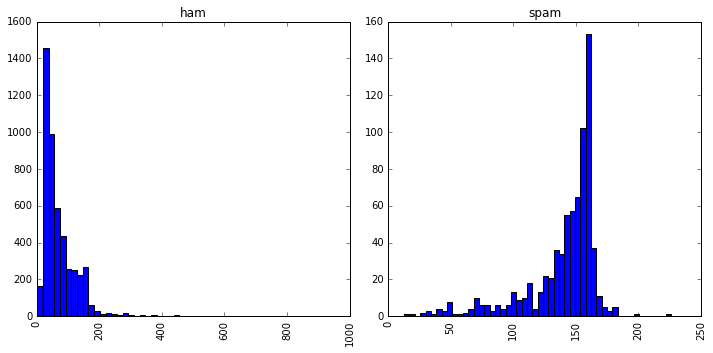

In [9]:
# plot length by label
df.hist(column='length', by='label', bins=50, figsize=(10,5))
plt.tight_layout();

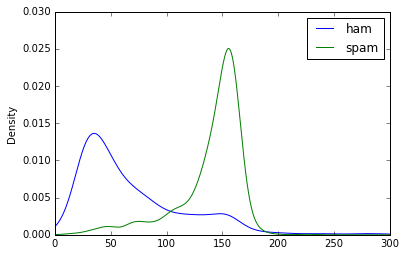

In [10]:
df.groupby('label')['length'].plot(kind='kde')
plt.legend()
plt.xlim(0,300);

In [11]:
df.groupby('label')['length'].describe()

label       
ham    count    4825.000000
       mean     71.146736  
       std      58.057736  
       min      2.000000   
       25%      33.000000  
       50%      52.000000  
       75%      92.000000  
       max      910.000000 
spam   count    747.000000 
       mean     139.763052 
       std      29.487832  
       min      13.000000  
       25%      134.000000 
       50%      151.000000 
       75%      158.000000 
       max      226.000000 
Name: length, dtype: float64

In [12]:
from scipy import stats

ham_length = df[df['label']=='ham']['length'].tolist()
spam_length = df[df['label']=='spam']['length'].tolist()
stats.ttest_ind(ham_length, spam_length)

Ttest_indResult(statistic=-31.673811321423354, pvalue=1.3470121662395232e-202)

From the plots and the statistics we can see that both the labels have a skewed distribution and that the means differ significantly. 
Where the mean for the ham resp spam messages are:
- mean ham messages: 71 
- mean spam messages: 139

## Data Preprocessing

#### Tokenize messages into a list of words

In [13]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [14]:
def preprocess(message):
    
    # convert bytes to unicode utf-8
    message = unicode(message, 'utf8')
    # tokenize
    tokens = word_tokenize(message)
    # convert to lowercase
    tokens = [word.lower() for word in tokens]
    
    return tokens


def preprocess_remove_stopwords(message):
    
    # convert bytes to unicode utf-8
    message = unicode(message, 'utf8')
    # tokenize
    tokens = word_tokenize(message)
    # remove non-alpha numeric characters
    tokens = [word for word in tokens if word.isalpha()]
    # convert to lowercase
    tokens = [word.lower() for word in tokens]
    # remove stopwords
    tokens = [word for word in tokens if not word in stopwords]

    return tokens


def preprocess_normalize(message):
    
    # convert bytes to unicode utf-8
    message = unicode(message, 'utf8')
    # tokenize
    tokens = word_tokenize(message)
    # convert to lowercase
    tokens = [word.lower() for word in tokens]
    # normalize words
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens


def preprocess_normalize_remove_stopwords(message):
    
    # convert bytes to unicode utf-8
    message = unicode(message, 'utf8')
    # tokenize
    tokens = word_tokenize(message)
    # remove non-alpha numeric characters
    tokens = [word for word in tokens if word.isapha()]
    # convert to lowercase
    tokens = [word.lower() for word in tokens]
    # remove stopwords
    tokens = [word for word in tokens if not word in stopwords]
    # normalize words
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens

In [15]:
# df['tokens'] = df['message'].apply(lambda x: preprocess_normalize(x))

In [16]:
df.head()

,label,message,label_binary,length
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives around here though",0,61


#### Convert messages to a vector space
The vector is shown as a TF-IDF matrix where each unique word represents a dimension and the rows indicate whether a word is present in the message.

TF-IDF consists of three steps:
- get the term frequency of each word per message
- weight the word frequencies by the number of occurences of a word across all messages: inverse document frequency
- normalize the vectors so that short messages get equal weight as long messages

In [17]:
vect = CountVectorizer(analyzer=preprocess_normalize)

In [18]:
vect.fit(df['message']) 

CountVectorizer(analyzer=<function preprocess_normalize at 0x111640758>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)

In [19]:
# print number of unique words
len(vect.vocabulary_)

8501

In [20]:
# transform data into a 'document-term matrix'
tf = vect.transform(df['message'])
tf

<5572x8501 sparse matrix of type '<type 'numpy.int64'>'
	with 89342 stored elements in Compressed Sparse Row format>

In [21]:
# convert the sparse matrix to a dense matrix
tf.toarray()[:5,:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [22]:
# examine the vocabulary of the document-term matrix
pd.DataFrame(tf.toarray(), columns=vect.get_feature_names()).iloc[0:5, 0:10]

,!,#,$,%,&,','','d,'m,'ok
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [23]:
# show the dimensions and number of words of the second message of the dataframe
print df['message'][1]
t = vect.transform([df['message'][1]])
print t

Ok lar... Joking wif u oni...
  (0, 90)	2
  (0, 4370)	1
  (0, 4581)	1
  (0, 5522)	1
  (0, 5558)	1
  (0, 7675)	1
  (0, 8096)	1


In [24]:
# check a word by location in the term frequency matrix
vect.get_feature_names()[90]

u'...'

#### Create the TF-IDF matrix

In [25]:
# TF-IDF requires as input the count vectorizer (vect.transform(df['column']))
tfidf_transformer = TfidfTransformer().fit(tf)
tfidf = tfidf_transformer.transform(tf)
print tfidf[1]

  (0, 8096)	0.401863670446
  (0, 7675)	0.18687924364
  (0, 5558)	0.508928177122
  (0, 5522)	0.26158935615
  (0, 4581)	0.381860102043
  (0, 4370)	0.431234276404
  (0, 90)	0.379953575157


The results of this TF-IDF matrix show the relative importancy of each word across the entire corpus.

In [26]:
# For example the word with the highest resp. lowest scores for the second message are:
print vect.get_feature_names()[5558]
print vect.get_feature_names()[7675]

oni
u


#### All together you get:

In [27]:
def tfidf_matrix(text_column): 
    
    # transform data into a 'document-term matrix'
    vect = CountVectorizer(analyzer=preprocess)
    tf = vect.fit_transform(text_column)
    
    # transform data into an inverse 'document-term matrix'    
    tfidf = TfidfTransformer()
    tfidf_tf = tfidf.fit_transform(tf)
    
    return tfidf_tf

## Run the model

### Create the entire pipeline for running the classification model

In [28]:
pipeline = Pipeline([('vect', CountVectorizer(analyzer=preprocess_normalize)), # strings to token integer counts
                    ('tfidf', TfidfTransformer()),                  # integer counts to weighted TF-IDF scores
                    ('classifier', MultinomialNB()),                # train on TF-IDF vectors w/ Naive Bayes classifier
                    ])

### Split data into train and test set

In [29]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df['message'], df['label_binary'], test_size=0.2)
# Xtrain, Xtest, ytrain, ytest = train_test_split(tfidf_tf, df['label_binary'], test_size=0.2)

print len(Xtrain)
print len(Xtest)

4457
1115


### Run and evaluate the model

For this analysis I use cross-validation to test the stability of the model with different subsets of training data.

In [30]:
# Perform a cross-validation with k = 10 on the training data
scores = cross_val_score(pipeline,             # steps to convert raw messages into TF-IDF matrix and run the classifier 
                         df['message'],        # data
                         df['label_binary'],   # labels
                         cv = 10,              # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring = 'accuracy', # which scoring metric?
                         n_jobs=-1,            # -1 to make it faster and use all CPUs
                         )
print scores
print '---'
print scores.mean(), scores.std()

[ 0.95340502  0.95878136  0.94444444  0.96057348  0.9516129   0.95152603
  0.94614004  0.94784173  0.94244604  0.95683453]
---
0.951360557468 0.00584053680304


The accuracy score on the validation set of all 10 samples are very similar, indicating that we normalized the dataset correctly. The standard deviations shows that there is not much variation around the mean.

#### Perform cross-validation and return predictions

In [58]:
ypred = cross_val_predict(pipeline, df['message'], df['label_binary'], cv=10)#, n_jobs=-1)

<b>Accuracy score:</b> The fraction (default) or the count (normalize=False) of correct predictions.

<b>Recall score:</b> The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

<b>Precision score:</b> The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

<b>Average precision score:</b> This score corresponds to the area under the precision-recall curve.

<b>ROC AUC score:</b> The roc_auc_score function computes the area under the receiver operating characteristic (ROC) curve. 

In [59]:
print "confusion matrix"
print confusion_matrix(df['label_binary'], ypred)
print '---'
print "accuracy:\t\t", accuracy_score(df['label_binary'], ypred)
print "recall:\t\t\t", recall_score(df['label_binary'], ypred)
print "precision:\t\t", precision_score(df['label_binary'], ypred)
print "average precision:\t", average_precision_score(df['label_binary'], ypred)
print "roc auc:\t\t", roc_auc_score(df['label_binary'], ypred)

confusion matrix
[[4825    0]
 [ 271  476]]
---
accuracy:		0.95136396267
recall:			0.637215528782
precision:		1.0
average precision:	0.842925783056
roc auc:		0.818607764391


#### Examples for messages that are predicted incorrectly

In [42]:
# false positives (ham incorrectly classified as spam)
df['message'][df['label_binary'] < ypred]

Series([], Name: message, dtype: object)

In [43]:
# false negatives (spam incorrectly classified as ham)
df['message'][df['label_binary'] > ypred][:2]

5     FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv 
15    XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL
Name: message, dtype: object

#### How much does the accuracy vary by the size of the sample data?

To explore the effect of the sample size of the training data we use the build in learning curve function of sklearn.

The learning curve function determines cross-validated training and test scores for different training
set sizes.

"A cross-validation generator splits the whole dataset k times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the
test set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size."

In [35]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and traning learning curve."""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X,
                                                            y,
                                                            cv=cv,
                                                            n_jobs=n_jobs,
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

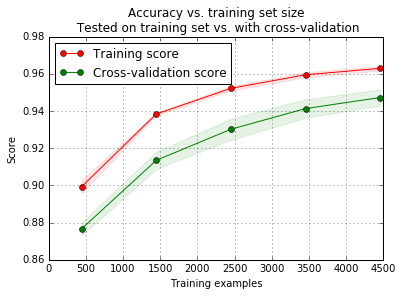

In [44]:
plot_learning_curve(pipeline, 
                    "Accuracy vs. training set size\n Tested on training set vs. with cross-validation", 
                    df['message'], df['label_binary'], cv=5);

## Parameter Tuning

For comparing various input for parameters, use the GridSearch function in sklearn.

### Naive Bayes

In [33]:
pipeline_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB()),
])

parameters_nb = {
#     'vect__analyzer': (preprocess, preprocess_normalize),
#     'vect__stop_words': (None, 'english'),
    'tfidf__use_idf': (True, False),
    'nb__alpha': (0.01, 0.05, 0.1),
    'nb__fit_prior' : (True, False),
}

In [34]:
# instantiate the grid
grid_nb = GridSearchCV(pipeline_nb, parameters_nb, cv=5, n_jobs=-1, verbose=1)
grid_nb.fit(Xtrain, ytrain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...=False,
         use_idf=True)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'nb__fit_prior': (True, False), 'nb__alpha': (0.01, 0.05, 0.1), 'tfidf__use_idf': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [91]:
# examine the best model

# Single best score achieved across all params (k)
print grid_nb.best_score_
print '---'
# Dictionary containing the parameters (k) used to generate that score
print grid_nb.best_params_
print '---'
# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print grid_nb.best_estimator_

0.985416199237
---
{'nb__fit_prior': True, 'tfidf__use_idf': True, 'nb__alpha': 0.05}
---
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...False,
         use_idf=True)), ('nb', MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))])


In [64]:
ypred = grid_nb.predict(Xtest)
print (confusion_matrix(ytest, ypred))
print (accuracy_score(ytest, ypred))
print (classification_report(ytest, ypred))

[[942   0]
 [ 64 109]]
0.942600896861
             precision    recall  f1-score   support

          0       0.94      1.00      0.97       942
          1       1.00      0.63      0.77       173

avg / total       0.95      0.94      0.94      1115



### Support Vector Machine

In [106]:
pipeline_svm = Pipeline([
    ('vect', CountVectorizer(analyzer=preprocess_normalize)),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC()),
])

parameters_svm = {
    'svm__kernel': ('linear', 'rbf'),
    'svm__C': (1, 10),
    'svm_shrinking': (True, False),
}

# parameters_svm = [
#   {'svm__C': [1, 10], 'svm__kernel': ['linear']},
#   {'svm__C': [1, 10], 'svm__kernel': ['rbf']},
# ]

In [107]:
# instantiate the grid
grid_svm = GridSearchCV(pipeline_svm, parameters_nb, cv=5, n_jobs=-1, verbose=1)
grid_svm.fit(Xtrain, ytrain)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   45.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=<function preprocess_normalize at 0x11441eaa0>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproc...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svm__C': (1, 10), 'svm__kernel': ('linear', 'rbf')},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [108]:
# examine the best model

# Single best score achieved across all params (k)
print grid_svm.best_score_
print '---'
# Dictionary containing the parameters (k) used to generate that score
print grid_svm.best_params_
print '---'
# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print grid_svm.best_estimator_

0.986089297734
---
{'svm__C': 10, 'svm__kernel': 'linear'}
---
Pipeline(steps=[('vect', CountVectorizer(analyzer=<function preprocess_normalize at 0x11441eaa0>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preproc...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


## Explore spam versus non spam words

### Fit the model and compute the occurences per word for each class 

In [51]:
Xtrain_dtm = vect.fit_transform(Xtrain)

In [45]:
nb = MultinomialNB()
nb.fit(Xtrain_dtm, ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [49]:
# get complete list of tokens
words = vect.get_feature_names()
words[:5]

[u'!', u'#', u'$', u'%', u'&']

In [48]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[ 699.,  207.,   13., ...,    0.,    0.,    4.],
       [ 417.,    1.,    3., ...,    1.,    1.,    0.]])

In [53]:
# number of samples for each class
nb.class_count_ 

array([ 3866.,   591.])

In [56]:
print len(df[df['label']=='ham'])
print len(df[df['label']=='spam'])

4825
747


Based on the number of times spam and non spam messages appear in the dataset, I assume that the first number in the array refers to the number of 'ham' messages. NB: maybe the list follows the columns in alphabetical order.

In [57]:
# number of times each token appears across all HAM messages
ham_token_count = nb.feature_count_[0, :]
# number of times each token appears across all SPAM messages
spam_token_count = nb.feature_count_[1, :]

In [58]:
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({'token': words, 'ham': ham_token_count, 'spam': spam_token_count}).set_index('token')
tokens.head()

,ham,spam
token,,
!,699.0,417.0
#,207.0,1.0
$,13.0,3.0
%,6.0,2.0
&,561.0,126.0


### Compute the spam ratio of each word

In [59]:
# add 1 to ham and spam counts to avoid dividing by 0
tokens['ham'] = tokens.ham + 1
tokens['spam'] = tokens.spam + 1

In [60]:
# convert the ham and spam counts into relative measures
tokens['ham'] = tokens.ham / nb.class_count_[0]
tokens['spam'] = tokens.spam / nb.class_count_[1]

In [62]:
# calculate the ratio of spam-to-ham for each token
tokens['spam_ratio'] = tokens.spam / tokens.ham

In [64]:
# examine the words that have a high spam ratio
tokens.sort_values('spam_ratio', ascending=False).head()

,ham,spam,spam_ratio
token,,,
claim,0.000259,0.155668,601.813875
prize,0.000259,0.120135,464.443316
tone,0.000259,0.098139,379.404399
won,0.000259,0.096447,372.862944
guarante,0.000259,0.065990,255.116751


## Topic analysis for spam messages

Explore whether we can distinguish different topics in the spam messages.
For the topic analysis I use the LDA algorithm. 

"In LDA, each document may be viewed as a mixture of various topics where each document is considered to have a set of topics that are assigned to it via LDA. This is identical to probabilistic latent semantic analysis (pLSA), except that in LDA the topic distribution is assumed to have a sparse Dirichlet prior. The sparse Dirichlet priors encode the intuition that documents cover only a small set of topics and that topics use only a small set of words frequently. In practice, this results in a better disambiguation of words and a more precise assignment of documents to topics."

For LDA we only use the term frequencies and don't normalize it to the inverse document term frequencies.
The result of LDA provides a probability for each topic.
To identify the most likely topic we extract the topic with the highest probability.

In [114]:
spam = df[df['label']=='spam']

747


For more variation between topics, stopwords are removed.

In [187]:
n_features = 1000
n_topics = 5
n_top_words = 10
        
vect = CountVectorizer(analyzer=preprocess_remove_stopwords, max_df=0.95, min_df=2, max_features=n_features)
tf = vect.fit_transform(spam['message'])
    
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5, n_jobs=-1)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=5,
             mean_change_tol=0.001, n_jobs=-1, n_topics=5, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [183]:
n_topics = 5
n_top_words = 10
feature_names = vect.get_feature_names()
    
# print words associated with topics
topic_words = []

for topic in lda.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([feature_names[i] for i in word_idx])

for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:10])))    

Topic 0: ur txt stop call customer free get service text mobile
Topic 1: call contact per prize u claim ur rate min draw
Topic 2: back see text hmv welcome answer go info help arcade
Topic 3: call free u stop text reply chat txt get send
Topic 4: call free mobile urgent claim nokia u cash txt prize


### Return the topic for each message 

In [184]:
# convert to arrays
tf_array = vect.fit_transform(spam['message']).toarray()
feature_names_array = np.array(vect.get_feature_names())

In [188]:
doctopic = lda.fit_transform(tf_array)

In [189]:
# scale the document-component matrix such that the component values associated with each document sum to one
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

In [190]:
doctopic[:5]

array([[ 0.00957497,  0.96137638,  0.00982641,  0.00958968,  0.00963258],
       [ 0.01341259,  0.14431079,  0.01368429,  0.23433157,  0.59426075],
       [ 0.01490355,  0.01350177,  0.24472474,  0.41008625,  0.31678368],
       [ 0.01186578,  0.01179944,  0.01186119,  0.95262196,  0.01185164],
       [ 0.01459043,  0.94198178,  0.01459051,  0.01442069,  0.01441659]])

#### Return the topic with the highest propability for each message

In [191]:
topic = []
for i in doctopic:
    topic.append(np.argmax(i))#, i.max()

#### Add topic as an extra column to the spam dataframe

In [192]:
topic = pd.Series(topic)
spam['topic'] = topic.values

In [193]:
spam.head()

,label,message,label_binary,length,tokens,topic
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1,155,"[free, entri, in, 2, a, wkli, comp, to, win, fa, cup, final, tkts, 21st, may, 2005, ., text, fa, to, 87121, to, receiv, entri, question, (, std, txt, rate, ), t, &, c, 's, appli, 08452810075over18, 's]",1
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",1,150,"[freemsg, hey, there, darl, it, 's, been, 3, week, 's, now, and, no, word, back, !, i, 'd, like, some, fun, you, up, for, it, still, ?, tb, ok, !, xxx, std, chgs, to, send, ,, å£1.50, to, rcv]",4
8,spam,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,1,160,"[winner, !, !, as, a, valu, network, custom, you, have, been, select, to, receivea, å£900, prize, reward, !, to, claim, call, 09061701461, ., claim, code, kl341, ., valid, 12, hour, onli, .]",3
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1,154,"[had, your, mobil, 11, month, or, more, ?, u, r, entitl, to, updat, to, the, latest, colour, mobil, with, camera, for, free, !, call, the, mobil, updat, co, free, on, 08002986030]",3
11,spam,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",1,136,"[six, chanc, to, win, cash, !, from, 100, to, 20,000, pound, txt, >, csh11, and, send, to, 87575, ., cost, 150p/day, ,, 6day, ,, 16+, tsandc, appli, repli, hl, 4, info]",1
